# Pendule Inversee

## 1- Theeorie du pendule inversee

- La figure ci-dessous montre un schéma du système utilisé dans cet exemple. Le pendule inversé est fixé à une extrémité sur le dessus d'un chariot avec une masse M. La rotation autour du point fixe est supposée avec frottement. Le bourrelet à l'extrémité du pendule a une masse m, tandis que la tige rigide reliant le bourrelet au chariot est sans masse. Le chariot est capable de se déplacer par rapport à la surface, c'est-à-dire uniquement dans la direction $\vec{x}$. Les forces agissant sur le talon sont la force gravitationnelle $\vec{G}$. La longueur de la tige sans masse est R, et le déplacement angulaire du pendule par rapport à $\vec{y}$ est donné par $\theta$.

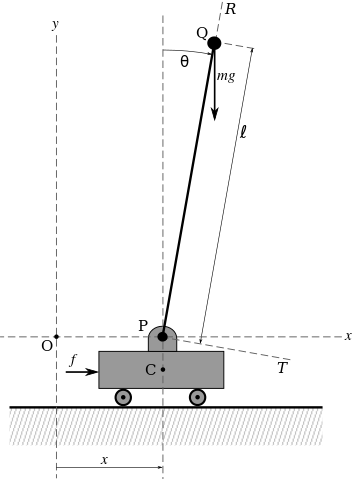

In [1]:
from IPython.display import Image
Image(filename='cart-pole-model.png') 

## 1.1. Equations de mouvement

Les equations du mouvement sont les suivantes

$$
(M+m)\ddot x = \left (mR\dot \theta^2 sin(\theta) - mR\ddot \theta cos(\theta) - kx -d \dot x \right )
$$

$$
\frac{b}{R}\dot \theta + m\ddot x cos(\theta) + mR\ddot \theta + mgsin(\theta) = 0
$$

- Sous forme vectorielle, nous voulons un vecteur X
$$
X = \begin{bmatrix}
x_0\\ 
x_1\\ 
x_2\\ 
x_3
\end{bmatrix} = \begin{bmatrix}
x\\ 
\theta\\ 
\dot x\\ 
\dot \theta
\end{bmatrix}
$$

- tel que:
$$
\frac{dX}{dt} = \frac{d}{dt} \begin{bmatrix}
x_0\\ 
x_1\\ 
x_2\\ 
x_3
\end{bmatrix} = \frac{d}{dt} \begin{bmatrix}
x\\ 
\theta\\ 
\dot x\\ 
\dot \theta
\end{bmatrix} =\begin{bmatrix}
\dot x = x_2\\ 
\dot \theta = x_3\\ 
\ddot x = \dot x_2\\ 
\ddot \theta = \dot x_3
\end{bmatrix} 
$$

- Les equations deviennent
$$
\dot x_2 = \frac{1}{M+m}\left (mRx_3^2 sin(x_1) - mR\dot x_3 cos(x_1) - kx_0 -d x_2 \right )
$$

- avec 
$$
\dot x_3 = \frac{-1}{mR} \left ( mgsin(x_1) + m\dot x_2 cos(x_1) + \frac{b}{R}x_3 \right )
$$

## 1.2. Description de la methode de resolution: Runge Kutta (Ordre 4)

Considérons une fonction continue \\(f(x,y)\\), où \\(x\\) est la variable indépendante et \\(y\\) est la variable dépendante :
\\[\frac{dy}{dx}=f(x,y).\\]
- Notre objectif est de trouver \\(y(x)\\) et pour y parvenir, nous devons :
* connaître la valeur de \\(y=y_0\\) à une valeur initiale de \\(x=x_0\\)
* avancer à partir du point initial en utilisant des pas finis de taille \\(\Delta x\\)
* savoir le taux de changement de \\(y\\) pour chaque étape dans \\(x\\)

Dans la méthode de Runge-Kutta d'ordre 4, la variable indépendante est incrémentée par pas et la nouvelle valeur de la variable dépendante est calculée à la fin de chaque pas selon :
\\[y_{i+1} = y_i + \frac{1}{6}(k_1+2k_2+2k_3+k_4),\\\\\\
x_{i+1} = x_i + \Delta x,\\]

où \\(\Delta x\\) est le pas, \\(k_1, k_2, k_3\\) et \\(k_4\\) sont calculées comme suit :
\\[k_1 = \Delta x f(x_i, y_i),\\\\\\
k_2 = \Delta x f(x_i + 0,5 \Delta x, y_i + 0,5 k_1),\\\\\\
k_3 = \Delta x f(x_i + 0,5 \Delta x, y_i + 0,5 k_2).\\\\\\
k_4 = \Delta x f(x_i + \Delta x, y_i + k_3).\\]

# 2. Simulation du systeme 

In [2]:
# Importation des libraries de base
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from progressbar import ProgressBar
%matplotlib inline 
import matplotlib 

In [3]:
def Eq(z, Eq_params):
    # Parmetres du modele
    M, m, R, k, g, b, d = Eq_params
    # Definition des equations du mouvement couples
    # z est le vecteur d'etat (positions et vitesses = Variables de l)
    x0, x1, x2, x3 = z
    
    # Vecteurs derives
    dx0dt = x2
    dx1dt = x3
    
    dx2dt = ( (1/(M+m))/ ( 1 - (m/(M+m))*(np.cos(x1)**2) ) )*(m*R*x3**2*np.sin(x1) - k*x0 - d*x2) + (1/(M+m))*np.cos(x1)*((m*g*np.sin(x1) + (b/R)*x3))
    
    dx3dt = (-1/m*R)*(m*g*np.sin(x1) + m*dx2dt*np.cos(x1) + (b/R)*x3)
    
    
    dxdt = np.array([dx0dt, dx1dt, dx2dt, dx3dt])
    
    return dxdt
    
    
    
def RK4(z, dt, Eq, Eq_params):
    
    # z etant le vecteur d'etat
    k1 = np.array(Eq(z, Eq_params))
    k2 = np.array(Eq(z + k1*dt/2, Eq_params))
    k3 = np.array(Eq(z + k2*dt/2, Eq_params))
    k4 = np.array(Eq(z + k3*dt, Eq_params))
    
    return z + dt/6 * (k1 + 2*k2 + 2*k3 + k4)

In [4]:
def Energie(z):
    x0, x1, x2, x3 = z
    
    U = m*g*R*np.cos(x1)
    T = 0.5*((m+M)*x2**2)
    
    return np.array([T, U])

In [5]:
# Resolution du systeme d'equations:

# Parametres de la resolution
periode = 10
pas = 0.01 
n = int(periode / pas)
# En fonction du temps
t = np.arange(0,periode,pas)

def solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0):
    Eq_params = np.array([M, m, R, k, g, b, d])
    Z = np.zeros((4, n)) # t = 0 : [x0_0, x1_0, x2_0, x3_0], t = 0.01 : [x0_1, x1_1, x2_1, x3_1] etc... jusqu'a "n"

    # Etat initial:
    Z[:, 0] = np.array([x0_0, x1_0, x2_0, x3_0])# ETAT INITIAL 

    pbar = ProgressBar()
    for i in pbar(range(n-1)):
        Z[:, i+1] = RK4(Z[:, i], pas, Eq, Eq_params)
    
    return Z

# 3. Resultats et Discussion

In [6]:
# Reference
"""
# Parametres du modele
model_params = {"M":10, "m":1, "R":5, "k":0.1, "g":9.81, "b":0.0, "d":2.2}
x0_0, x1_0, x2_0, x3_0 = (0.0, 0.0, 0.1, 0.0)

M = model_params["M"]
m = model_params["m"]
R = model_params["R"]
k = model_params["k"]
g = model_params["g"]
b = model_params["b"]
d = model_params["d"]
""";

- Nous allons examiner des cas avec une vitesse initiale du chariot fixee, la position initiale est a zero, la vitesse angulaire initiale est nulle et l'angle initial est nul.

### Effet des frottements:
#### Effet du coeffiscient de frottement "b":

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


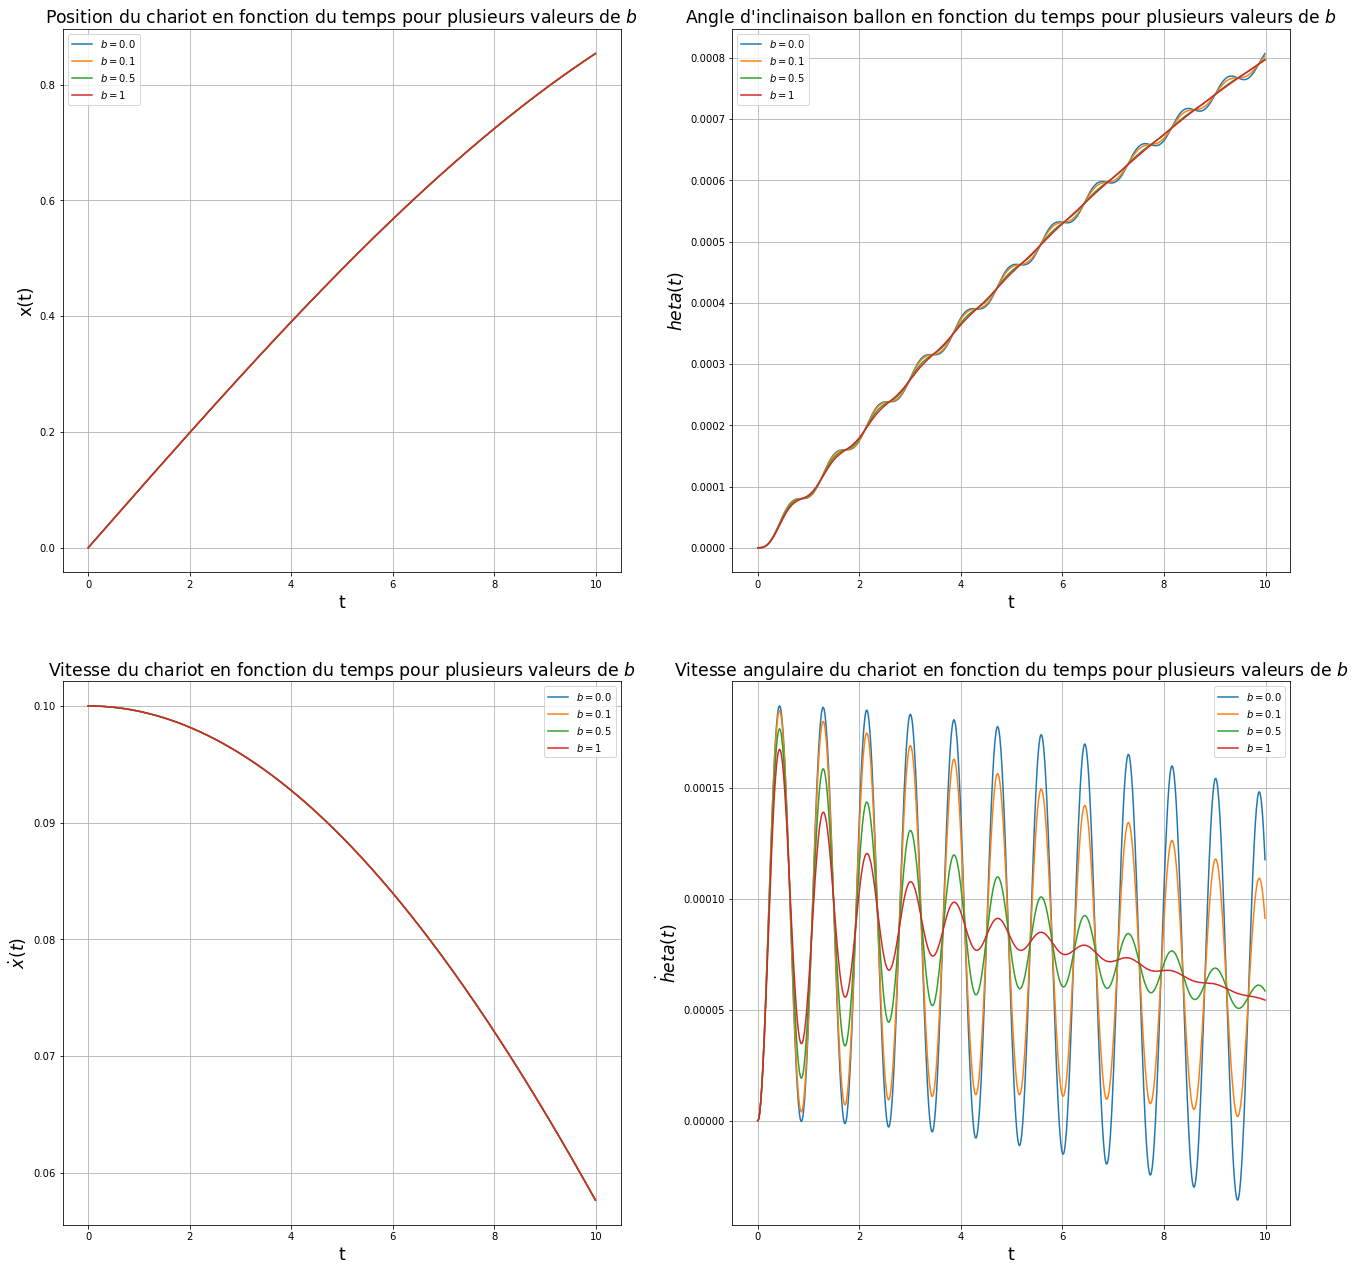

In [7]:
# Parametres du modele
model_params = {"M":10, "m":1, "R":5, "k":0.1, "g":9.81, "b":0.0, "d":0.0}
x0_0, x1_0, x2_0, x3_0 = (0.0, 0.0, 0.1, 0.0)

M = model_params["M"]
m = model_params["m"]
R = model_params["R"]
k = model_params["k"]
g = model_params["g"]
d = model_params["d"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = [22, 22], nrows=2, ncols = 2)
b_coeff = [0.0, 0.1, 0.5, 1]
temoin = "b"
leg = [f"${temoin} = {b_coeff[0]}$", f"${temoin} = {b_coeff[1]}$", f"${temoin} = {b_coeff[2]}$", f"${temoin} = {b_coeff[3]}$"]

# En fonction du temps
for b in b_coeff:
    Z = solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0)
    x, theta, xp, thetap = Z[0,:], Z[1,:], Z[2,:], Z[3,:]

    ax1.plot(t, x)
    ax1.set_title(f"Position du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax1.set_xlabel("t", size = "xx-large")
    ax1.set_ylabel("x(t)", size = "xx-large")
    ax1.grid(True)
    ax1.legend(leg)
    
    ax3.plot(t, xp)
    ax3.set_title(f"Vitesse du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax3.set_xlabel("t", size = "xx-large")
    ax3.set_ylabel("$\dot x(t)$", size = "xx-large")
    ax3.grid(True)
    ax3.legend(leg)
    
    
    ax2.plot(t, theta)
    ax2.set_title(f"Angle d'inclinaison ballon en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax2.set_xlabel("t", size = "xx-large")
    ax2.set_ylabel("$\theta(t)$", size = "xx-large")
    ax2.grid(True)
    ax2.legend(leg)
    
    ax4.plot(t, thetap)
    ax4.set_title(f"Vitesse angulaire du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax4.set_xlabel("t", size = "xx-large")
    ax4.set_ylabel("$\dot \theta(t)$", size = "xx-large")
    ax4.grid(True)
    ax4.legend(leg)

plt.show()

In [8]:
#### Effet du parametre de frottement "d" 

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


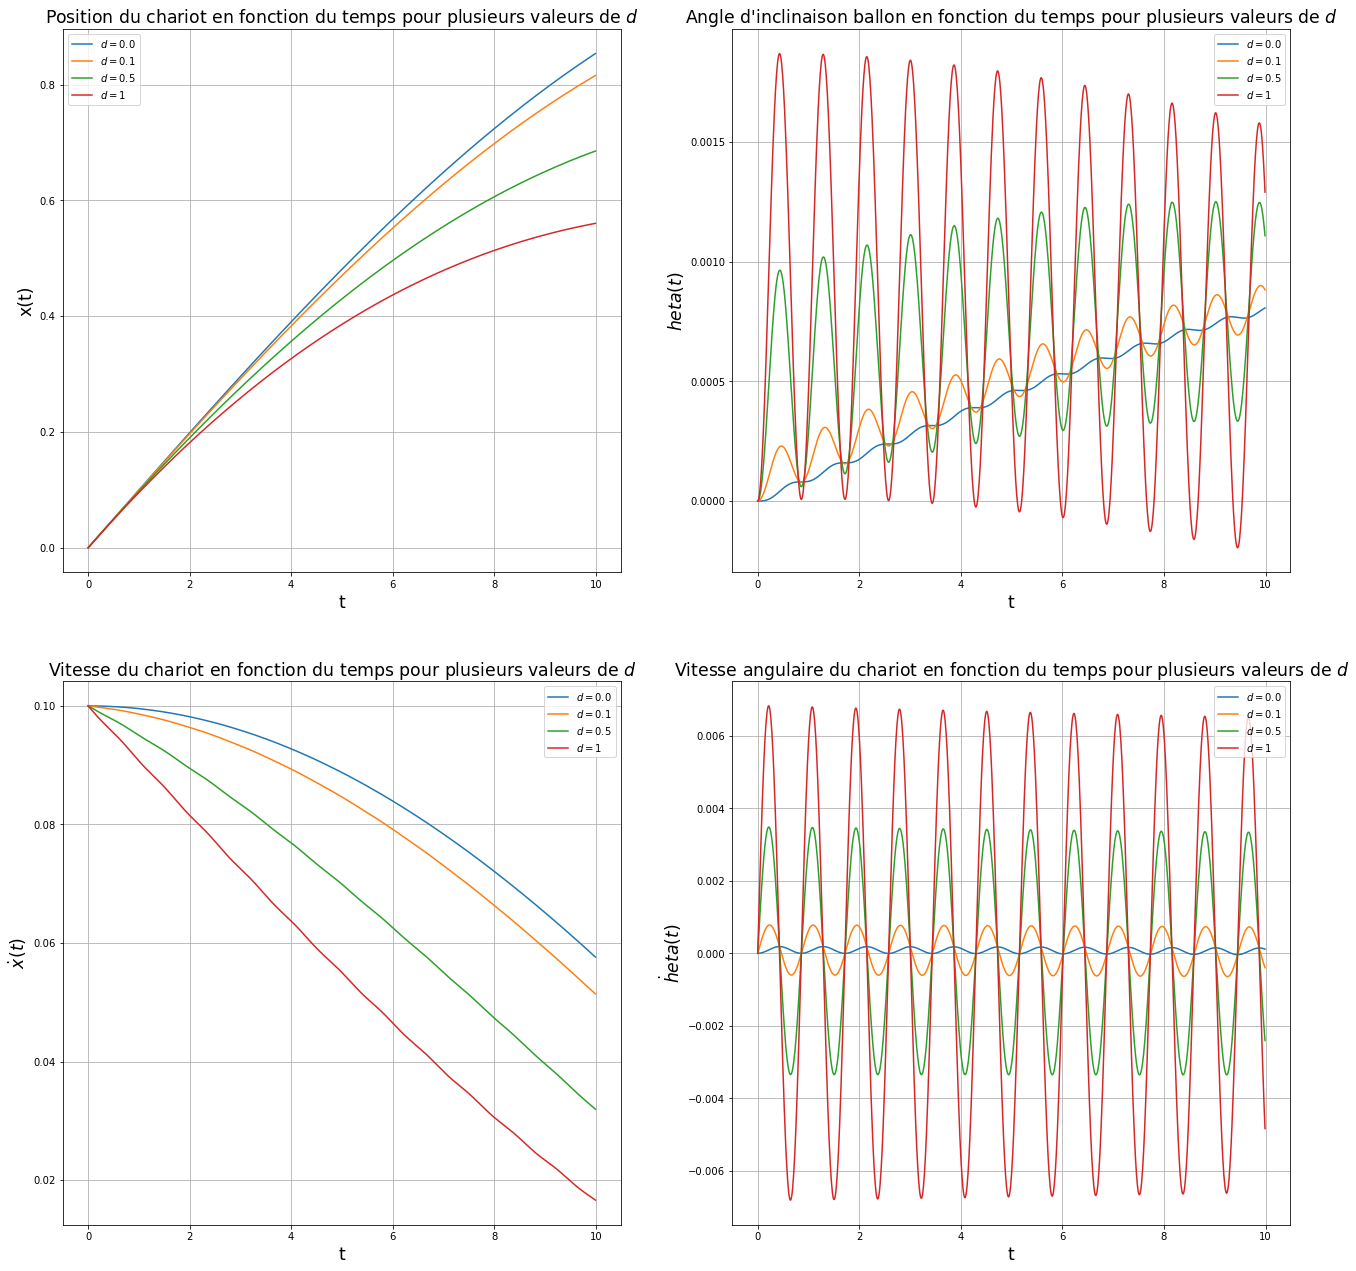

In [9]:
# Parametres du modele
model_params = {"M":10, "m":1, "R":5, "k":0.1, "g":9.81, "b":0.0, "d":0.0}
x0_0, x1_0, x2_0, x3_0 = (0.0, 0.0, 0.1, 0.0)

M = model_params["M"]
m = model_params["m"]
R = model_params["R"]
k = model_params["k"]
g = model_params["g"]
b = model_params["b"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = [22, 22], nrows=2, ncols = 2)
d_coeff = [0.0, 0.1, 0.5, 1]
temoin = "d"
leg = [f"${temoin} = {d_coeff[0]}$", f"${temoin} = {d_coeff[1]}$", f"${temoin} = {d_coeff[2]}$", f"${temoin} = {d_coeff[3]}$"]

# En fonction du temps
for d in d_coeff:
    Z = solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0)
    x, theta, xp, thetap = Z[0,:], Z[1,:], Z[2,:], Z[3,:]

    ax1.plot(t, x)
    ax1.set_title(f"Position du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax1.set_xlabel("t", size = "xx-large")
    ax1.set_ylabel("x(t)", size = "xx-large")
    ax1.grid(True)
    ax1.legend(leg)
    
    ax3.plot(t, xp)
    ax3.set_title(f"Vitesse du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax3.set_xlabel("t", size = "xx-large")
    ax3.set_ylabel("$\dot x(t)$", size = "xx-large")
    ax3.grid(True)
    ax3.legend(leg)
    
    
    ax2.plot(t, theta)
    ax2.set_title(f"Angle d'inclinaison ballon en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax2.set_xlabel("t", size = "xx-large")
    ax2.set_ylabel("$\theta(t)$", size = "xx-large")
    ax2.grid(True)
    ax2.legend(leg)
    
    ax4.plot(t, thetap)
    ax4.set_title(f"Vitesse angulaire du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax4.set_xlabel("t", size = "xx-large")
    ax4.set_ylabel("$\dot \theta(t)$", size = "xx-large")
    ax4.grid(True)
    ax4.legend(leg)

plt.show()

#### Cas sans frottements et avec raideur variee

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


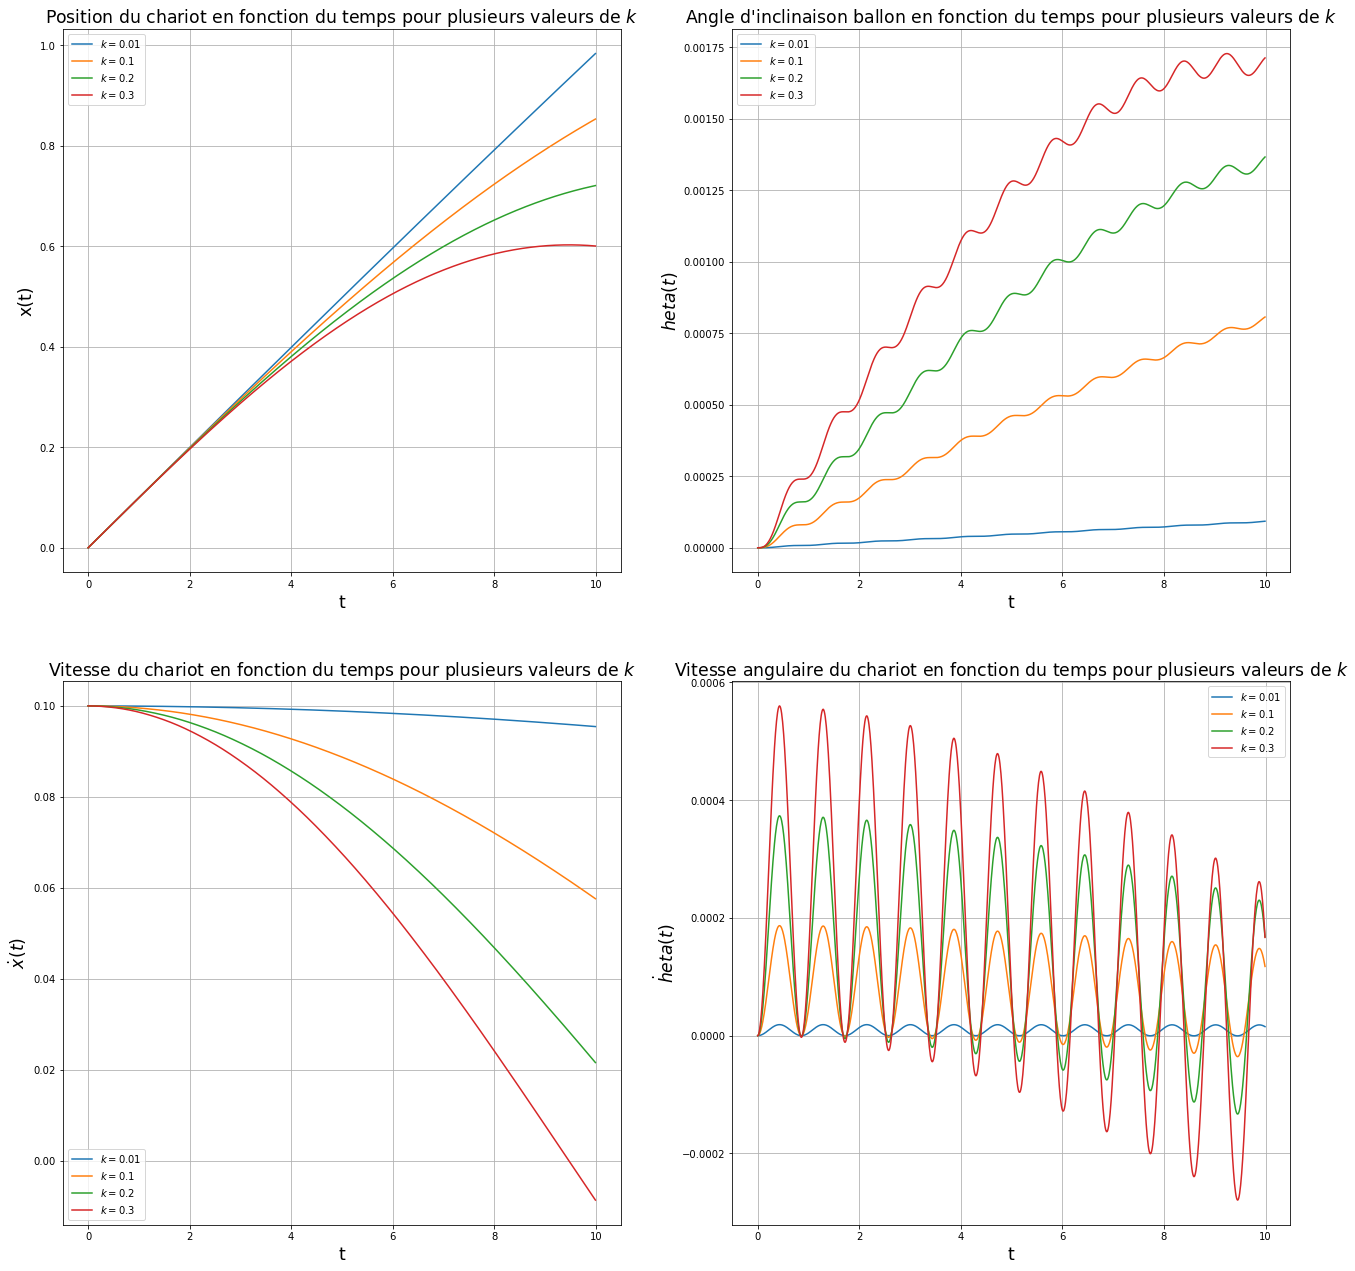

In [10]:
# Parametres du modele
model_params = {"M":10, "m":1, "R":5, "k":0.0, "g":9.81, "b":0, "d":0.0}
x0_0, x1_0, x2_0, x3_0 = (0.0, 0.0, 0.1, 0.0)

M = model_params["M"]
m = model_params["m"]
R = model_params["R"]
#k = model_params["k"]
g = model_params["g"]
b = model_params["b"]
d = model_params["d"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize = [22, 22], nrows=2, ncols = 2)
k_coeff = [0.01, 0.1, 0.2, 0.3]
temoin = "k"
leg = [f"${temoin} = {k_coeff[0]}$", f"${temoin} = {k_coeff[1]}$", f"${temoin} = {k_coeff[2]}$", f"${temoin} = {k_coeff[3]}$"]

# En fonction du temps
for k in k_coeff:
    Z = solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0)
    x, theta, xp, thetap = Z[0,:], Z[1,:], Z[2,:], Z[3,:]

    ax1.plot(t, x)
    ax1.set_title(f"Position du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax1.set_xlabel("t", size = "xx-large")
    ax1.set_ylabel("x(t)", size = "xx-large")
    ax1.grid(True)
    ax1.legend(leg)
    
    ax3.plot(t, xp)
    ax3.set_title(f"Vitesse du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax3.set_xlabel("t", size = "xx-large")
    ax3.set_ylabel(r"$\dot x(t)$", size = "xx-large")
    ax3.grid(True)
    ax3.legend(leg)
    
    
    ax2.plot(t, theta)
    ax2.set_title(f"Angle d'inclinaison ballon en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax2.set_xlabel("t", size = "xx-large")
    ax2.set_ylabel(r"$\theta(t)$", size = "xx-large")
    ax2.grid(True)
    ax2.legend(leg)
    
    ax4.plot(t, thetap)
    ax4.set_title(f"Vitesse angulaire du chariot en fonction du temps pour plusieurs valeurs de ${temoin}$", size = "xx-large")
    ax4.set_xlabel("t", size = "xx-large")
    ax4.set_ylabel(r"$\dot \theta(t)$", size = "xx-large")
    ax4.grid(True)
    ax4.legend(leg)

plt.show()

#### Effet du rapport de Masse m/M:
- Nous examineaons ici l'effet du rapport de masse m/M

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|


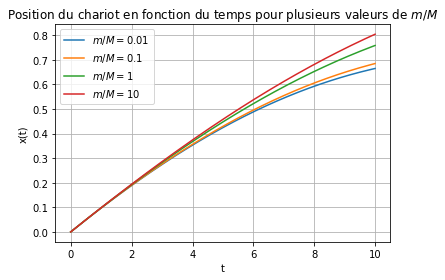

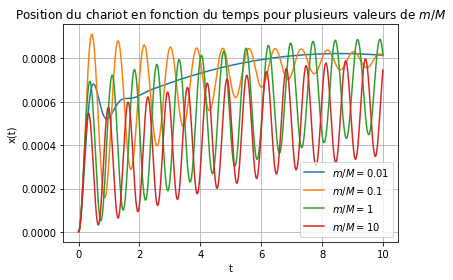

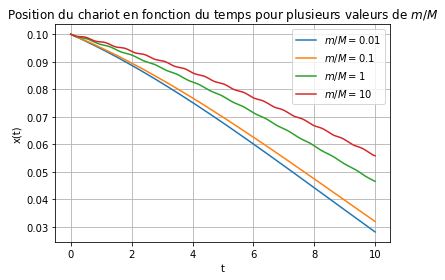

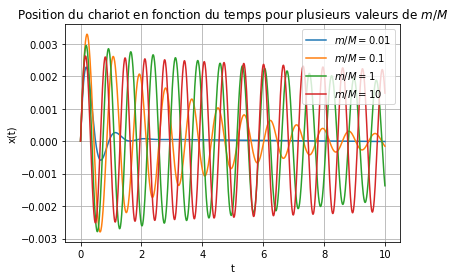

In [11]:
# Parametres du modele
model_params = {"R":5, "k":0.1, "g":9.81, "b":0.5, "d":0.5}
x0_0, x1_0, x2_0, x3_0 = (0.0, 0.0, 0.1, 0.0)

R = model_params["R"]
k = model_params["k"]
g = model_params["g"]
b = model_params["b"]
d = model_params["d"]

fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()
fig, ax4 = plt.subplots()


M = 10
rapport = [0.01, 0.1, 1, 10]
# En fonction du temps
for r in rapport:
    m = r*M
    Z = solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0)
    x, theta, xp, thetap = Z[0,:], Z[1,:], Z[2,:], Z[3,:]

    ax1.plot(t, x)
    ax1.set_title("Position du chariot en fonction du temps pour plusieurs valeurs de $m/M$")
    ax1.set_xlabel("t")
    ax1.set_ylabel("x(t)")
    ax1.grid(True)
    ax1.legend(["$m/M = 0.01$", "$m/M = 0.1$", "$m/M = 1$", "$m/M = 10$"])

    ax2.plot(t, theta)
    ax2.set_title("Position du chariot en fonction du temps pour plusieurs valeurs de $m/M$")
    ax2.set_xlabel("t")
    ax2.set_ylabel("x(t)")
    ax2.grid(True)
    ax2.legend(["$m/M = 0.01$", "$m/M = 0.1$", "$m/M = 1$", "$m/M = 10$"])
    
    ax3.plot(t, xp)
    ax3.set_title("Position du chariot en fonction du temps pour plusieurs valeurs de $m/M$")
    ax3.set_xlabel("t")
    ax3.set_ylabel("x(t)")
    ax3.grid(True)
    ax3.legend(["$m/M = 0.01$", "$m/M = 0.1$", "$m/M = 1$", "$m/M = 10$"])
    
    ax4.plot(t, thetap)
    ax4.set_title("Position du chariot en fonction du temps pour plusieurs valeurs de $m/M$")
    ax4.set_xlabel("t")
    ax4.set_ylabel("x(t)")
    ax4.grid(True)
    ax4.legend(["$m/M = 0.01$", "$m/M = 0.1$", "$m/M = 1$", "$m/M = 10$"])

plt.show()

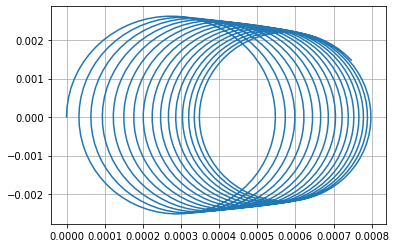

In [12]:
# Espace des phases
plt.plot(theta, thetap)
plt.grid(True)
plt.show()

## 3.1. Dans l'espace des phases

In [ ]:
# Lancer la simulation   
rapport = 10
m = 0.1
M = rapport*m

solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0)
x, theta, xp, thetap = Z[0,:], Z[1,:], Z[2,:], Z[3,:]

In [ ]:
# Espace des phases
plt.plot(x, xp)
plt.grid(True)
plt.show()

In [ ]:
# En fonction du temps
plt.plot(t, xp)
plt.grid(True)
plt.show()

# Animation

In [13]:
from matplotlib import animation

In [14]:
def cartX(x_1):
    return np.array([x_1 - R/8, x_1 + R/8, x_1 + R/8, x_1 - R/8, x_1 - R/8])

In [38]:
def generateAnimationWithPhaseSpace(Z, l = R, figSizeX=12, figSizeY=9, name = "Test.gif"):
    
    X = Z[0] + l*np.sin(Z[1])                           # x-coordinates of bead
    Y = l*np.cos(Z[1])                                  # y-coordinates of bead
    cartY = np.array([l/16, l/16, -l/16, -l/16, l/16])  # y-coordinates of cart corners

    fig = plt.figure(figsize=(figSizeX, figSizeY), dpi=200)
    # Axis limitations
    plt.subplot(2, 2, (1, 3))
    xMin = np.min(X) - l/2 
    xMax = np.max(X) + l/2
    # Adjust the y-limitations such that a circle looks like a circle.
    # i.e. no scaling.
    xDomain = xMax - xMin
    yDomain = xDomain*2*figSizeY/figSizeX
    plt.xlim(xMin, xMax)
    plt.ylim(0, yDomain + 0.01*yDomain)

    # Defining the different elements in the animation
    surface, = plt.plot([xMin, xMax], [-l/16, -l/16], color='black', linewidth=1)    # The surface
    tail, = plt.plot(X[0], Y[0], '--', color="blue")            # Previous position of the pendulum bead
    cart, = plt.plot(cartX(Z[0, 0]), cartY, color="red")        # The cart 
    rod, = plt.plot([Z[0, 0], X[0]], [0, Y[0]], color="black")  # The massless pendulum rod of length l
    bead, = plt.plot(X[0], Y[0], 'o', color="black", ms=4)      # The pendulum bead

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Inverted pendulum on cart")
    
    # Phase-space plot of the rod angle theta
    plt.subplot(222)
    plt.title("Rod angle in phase-space")
    anglePath, = plt.plot(Z[1], Z[3])
    angleFinal, = plt.plot(Z[1, -1], Z[3, -1], 'o', label="Point initial")
    angleCurrent, = plt.plot(Z[1, 0], Z[3, 0], '*', label="instant t")
    plt.xlabel(r'$\theta$ [rad]')
    plt.ylabel(r'$\dot{\theta}$ [rad/s]')
    plt.legend(loc='best')
    plt.grid(linestyle=":")
    
    # Phase-space plot of the cart position x.
    plt.subplot(224)
    plt.title("Cart position in phase-space")
    cartPath, = plt.plot(Z[0], Z[2])
    cartFinal, = plt.plot(Z[0, -1], Z[2, -1], 'o', label="Point initial")
    cartCurrent, = plt.plot(Z[0, 0], Z[2, 0], '*', label="instant t")
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$\dot{x}$ [m/s]')
    plt.legend(loc='best')
    plt.grid(linestyle=":")    
    
    # Calculate the number of frames
    FPS = 5
    framesNum = int(FPS*periode)
    dataPointsPerFrame = int(n/framesNum)

    # Animation function. This is called sequentially
    def animate(j):
        time = j*dataPointsPerFrame
        
        # Updating each element every time 
        tail.set_xdata(X[:time])
        tail.set_ydata(Y[:time])
        cart.set_xdata(cartX(Z[0, time])) 
        cart.set_ydata(cartY)
        rod.set_xdata([Z[0, time], X[time]])
        rod.set_ydata([0, Y[time]])
        bead.set_xdata(X[time])
        bead.set_ydata(Y[time])
        
        angleCurrent.set_xdata(Z[1, time])
        angleCurrent.set_ydata(Z[3, time])
        anglePath.set_xdata(Z[1, :time])
        anglePath.set_ydata(Z[3, :time])
        cartCurrent.set_xdata(Z[0, time])
        cartCurrent.set_ydata(Z[2, time])
        cartPath.set_xdata(Z[0, :time])
        cartPath.set_ydata(Z[2, :time])

    print(framesNum)
    
    # Create animation
    
    anim = animation.FuncAnimation(fig, animate, frames=framesNum)
    
    # Save animation.
    # If this don't work for you, try using another writer 
    # (ffmpeg, mencoder, imagemagick), or another file extension
    # (.mp4, .gif, .ogg, .ogv, .avi etc.). Make sure that you
    # have the codec and the writer installed on your system.
    anim.save(name, writer='pillow', fps=FPS)
    
    # Close plot
    plt.close(anim._fig)

    # Display the animation
    with open(name, 'rb') as file:
        display(Image(file.read()))
    #"""

In [39]:
# Parameteres de l'animation
model_params = {"M":5, "m":1, "R":2.5, "k":0.8, "g":9.81, "b":0.7, "d":2.2}
x0_0, x1_0, x2_0, x3_0 = (0.0, 0.0, 0.1, 0.0)

M = model_params["M"]
m = model_params["m"]
R = model_params["R"]
k = model_params["k"]
g = model_params["g"]
b = model_params["b"]
d = model_params["d"]

Z = solve(M, m, R, k, g, b, d, x0_0, x1_0, x2_0, x3_0)
x, theta, xp, thetap = Z[0,:], Z[1,:], Z[2,:], Z[3,:]

100% |########################################################################|


In [40]:
# Animation
generateAnimationWithPhaseSpace(Z, R, figSizeX=12, figSizeY=9)

50
